In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_ann.kneighbors.annoy import AnnoyTransformer

In [2]:
adata = sc.read_h5ad('/mnt/storage/Daniele/atlases/mouse/12_mouse_all_integration.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 622444 × 21469
    obs: 'donor_id', 'disease', 'model', 'barcoded', 'sex', 'strain', 'genotype', 'treatment', 'cell_filtering', 'sampleID', 'larry_positive', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'leiden_0.5', 'Level_0', 'leiden_myeloid_level_1', 'Level_1', 'leiden_lymphoid_level_1', 'leiden_fibroblast_level_1', 'leiden_endothelial_level_1', 'leiden_epithelial_level_1', 'total_counts_malat', 'log1p_total_counts_malat', 'pct_counts_malat', 'batch', 'Level_1_label_transfer', 'leiden_1.0', 'leiden_1.5', 'Level_1_refined', 'Sample', 'Dataset', 'Sample_unique', 'provenance', 'leiden', 'technology'
    var: 'Manual_genes'
    obsm: 'DRVI_emb', 'X_pca', 'X_scANVI', 'X_umap', 'bin_edg

In [4]:
sc.pp.neighbors(adata, transformer=AnnoyTransformer(15), use_rep='scANVI_emb')

/home/daniele/miniconda3/envs/scmouse_atlas/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sc.tl.umap(adata)

## annotation

In [6]:
threshold = 0

In [7]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

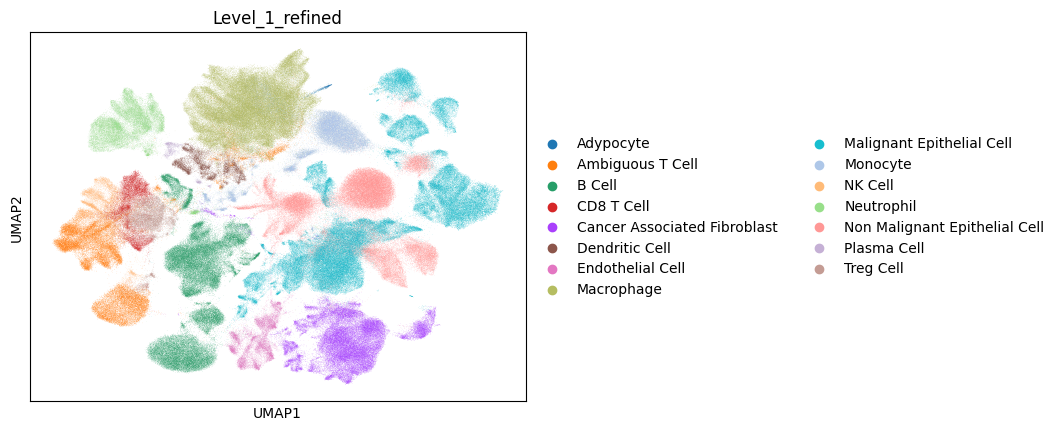

In [8]:
sc.pl.umap(adata, color = 'Level_1_refined')

In [9]:
adata.obs['Level_1_refined'].unique().tolist()

['Malignant Epithelial Cell',
 'Cancer Associated Fibroblast',
 'Non Malignant Epithelial Cell',
 'CD8 T Cell',
 'NK Cell',
 'Endothelial Cell',
 'Macrophage',
 'Neutrophil',
 'Ambiguous T Cell',
 'Treg Cell',
 'Monocyte',
 'Dendritic Cell',
 'B Cell',
 'Plasma Cell',
 'Adypocyte']

In [112]:
dictionary_maps = []

## T cells

In [65]:
T = adata[adata.obs['Level_1_refined'].isin(["CD8 T Cell", "Ambiguous T Cell", "Treg Cell"])].copy()

In [66]:
t_cell_markers = {
    "CD4+ T Cell": ["Cd4", "Il7r", "Tcf7", "Lck"],
    "CD8+ T Cells": ["Cd8a", "Cd8b1", "Gzma", "Gzmb"],
    "T-reg": ["Foxp3", "Il2ra", "Ctla4"],
}

In [ ]:
for cell_type, markers in t_cell_markers.items():
    sc.tl.score_genes(T, gene_list=markers, score_name=cell_type)
celltypes = []
scores = T.obs[list(t_cell_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(t_cell_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

T.obs['celltype'] = celltypes


In [110]:
T.obs['celltype'].value_counts()

CD4+ T Cell     26578
CD8+ T Cells    18860
Missclassifi    17175
T-reg           12469
Name: celltype, dtype: int64

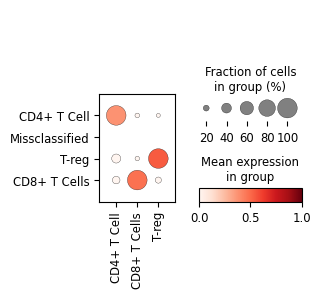

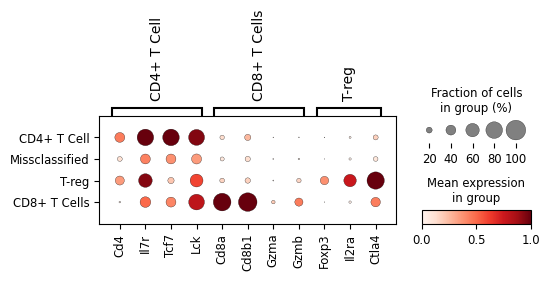

In [111]:
T.obs['celltype'].replace('Missclassifi', 'Missclassified', inplace=True)
sc.pl.dotplot(T, groupby = 'celltype', var_names = list(t_cell_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(T, groupby = 'celltype', var_names = t_cell_markers, vmax=1, vmin=0)

In [113]:
t_cells_map = {k:v for k,v in zip(list(T.obs_names), list(T.obs.celltype))}
dictionary_maps.append(t_cells_map)

## Neutrophils

In [70]:
N = adata[adata.obs['Level_1_refined'].isin(["Neutrophil"])].copy()

In [71]:
neutrophil_markers = {
    "Neutrophil - N0": [
        "S100a8", "Cxcr2", "Sell",
    ],
    "Neutrophil - N1": [
        "S100a8", "Tnf", "Stat1"
    ],
    "Neutrophil - N2": ["S100a8", "Vegfa", "Tgfb1", "Il10"],
}

In [72]:
for cell_type, markers in neutrophil_markers.items():
    sc.tl.score_genes(N, gene_list=markers, score_name=cell_type)
celltypes = []
scores = N.obs[list(neutrophil_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(neutrophil_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

N.obs['celltype'] = celltypes


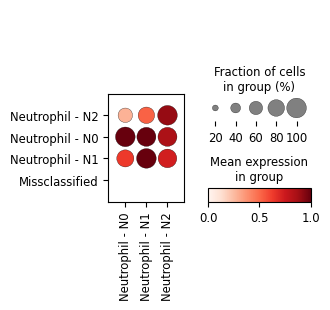

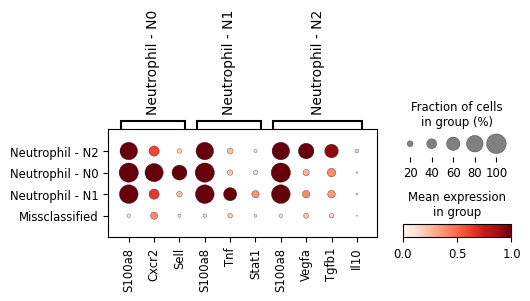

In [73]:
sc.pl.dotplot(N,  groupby = 'celltype', var_names = list(neutrophil_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(N,  groupby = 'celltype', var_names = neutrophil_markers, vmax=1, vmin=0)

In [74]:
N.obs['celltype'].unique().tolist()

['Neutrophil - N2', 'Neutrophil - N0', 'Neutrophil - N1', 'Missclassified']

In [114]:
neutro_cells_map = {k:v for k,v in zip(list(N.obs_names), list(N.obs.celltype))}
dictionary_maps.append(neutro_cells_map)

## Dendritic

In [76]:
D = adata[adata.obs['Level_1_refined'].isin(["Dendritic Cell"])].copy()

In [77]:
dendritic_markers = {
    "Dendritic Cell - cDC1": ["Xcr1", "Clec9a", "Batf3", "Irf8"],
    "Dendritic Cell - cDC2": ["Itgax", "Sirpa", "Irf4"],
    "Dendritic Cell - pDC": ["Siglech", "Bst2", "Irf7", "Tcf4"],
}


In [78]:
for cell_type, markers in dendritic_markers.items():
    sc.tl.score_genes(D, gene_list=markers, score_name=cell_type)
celltypes = []
scores = D.obs[list(dendritic_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(dendritic_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

D.obs['celltype'] = celltypes


In [79]:
dendritic_markers

{'Dendritic Cell - cDC1': ['Xcr1', 'Clec9a', 'Batf3', 'Irf8'],
 'Dendritic Cell - cDC2': ['Itgax', 'Sirpa', 'Irf4'],
 'Dendritic Cell - pDC': ['Siglech', 'Bst2', 'Irf7', 'Tcf4']}

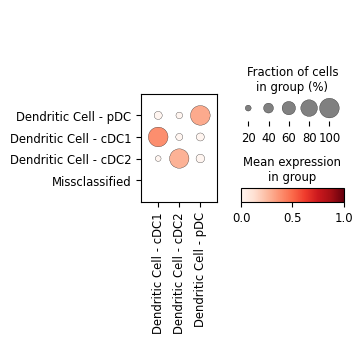

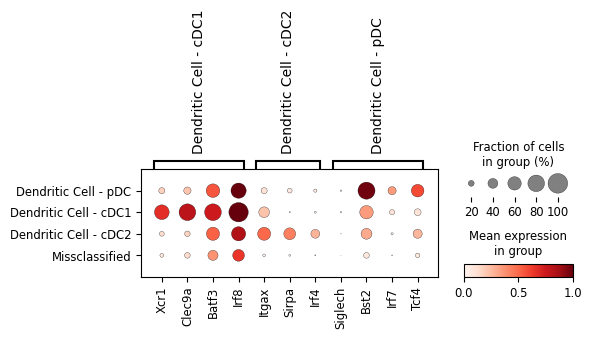

In [80]:
D.obs['celltype'].replace({'Miss': 'Missclassified'}, inplace=True)
sc.pl.dotplot(D,  groupby = 'celltype', var_names = list(dendritic_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(D,  groupby = 'celltype', var_names = dendritic_markers, vmax=1, vmin=0)

In [81]:
D.obs['celltype'].unique().tolist()

['Dendritic Cell - pDC',
 'Dendritic Cell - cDC1',
 'Dendritic Cell - cDC2',
 'Missclassified']

In [115]:
dendr_cells_map = {k:v for k,v in zip(list(D.obs_names), list(D.obs.celltype))}
dictionary_maps.append(dendr_cells_map)

## Macrophages

In [83]:
M = adata[adata.obs['Level_1_refined'].isin(["Macrophage"])].copy()

In [84]:
macrophage_markers = {
    "Macrophage - M1 TAM": [
        "Il1b", "Cd86",
    ],
    "Macrophage - M2 TAM": [
        "Icam1", "Stat1",
    ],
    "Macrophage - angiogenic TAM": [
        "Vcan", "Vegfa"
    ],
    "Macrophage - lipid processing TAM": [
        "Gpnmb"
    ],
    
}

In [85]:
for cell_type, markers in macrophage_markers.items():
    sc.tl.score_genes(M, gene_list=markers, score_name=cell_type)
celltypes = []
scores = M.obs[list(macrophage_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(macrophage_markers.keys()))[max_indices]

max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

M.obs['celltype'] = celltypes


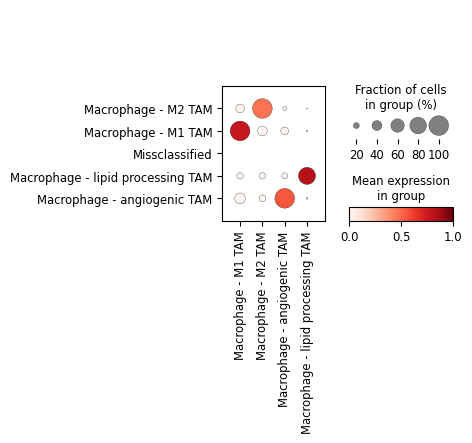

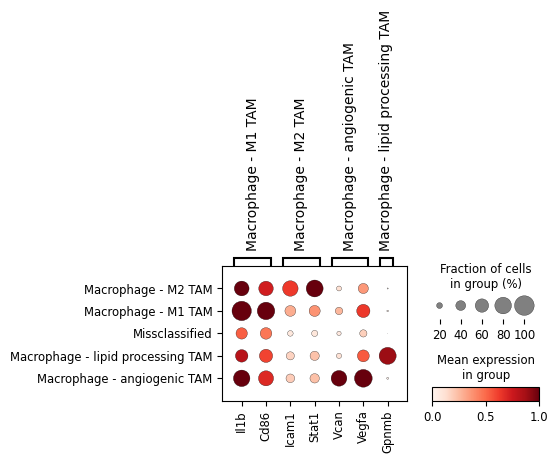

In [86]:
sc.pl.dotplot(M, groupby = 'celltype', var_names = list(macrophage_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(M, groupby = 'celltype', var_names = macrophage_markers, vmax=1, vmin=0)

In [87]:
M.obs['celltype'].unique().tolist()

['Macrophage - M2 TAM',
 'Macrophage - M1 TAM',
 'Missclassified',
 'Macrophage - lipid processing TAM',
 'Macrophage - angiogenic TAM']

In [116]:
machrophage_cells_map = {k:v for k,v in zip(list(M.obs_names), list(M.obs.celltype))}
dictionary_maps.append(machrophage_cells_map)

## CAFs

In [89]:
CAF = adata[adata.obs['Level_1_refined'].isin(["Cancer Associated Fibroblast"])].copy()

In [90]:
caf_markers = {
    "Fibroblast": ["Pdgfra", "Pdgfrb", "S100a4", "Vim", "Pdpn", "Des"],
    "myCAF": ["Acta2", "Tagln", "Myl9", "Tgfb1", "Col1a1", "Col3a1"],
    "iCAF": ["Il6", "Lif", "Cxcl12", "Ccl2", "Pdgfa", "Il1a", "Il1b"],
    "apCAF": ["H2-Ab1", "Cd74", "H2-Aa"],
}

In [91]:
for cell_type, markers in caf_markers.items():
    sc.tl.score_genes(CAF, gene_list=markers, score_name=cell_type)
celltypes = []
scores = CAF.obs[list(caf_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(caf_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

CAF.obs['celltype'] = celltypes


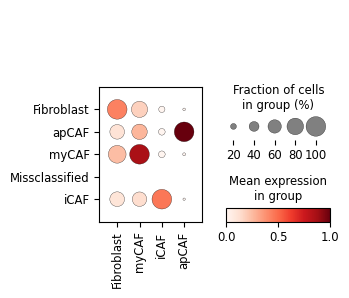

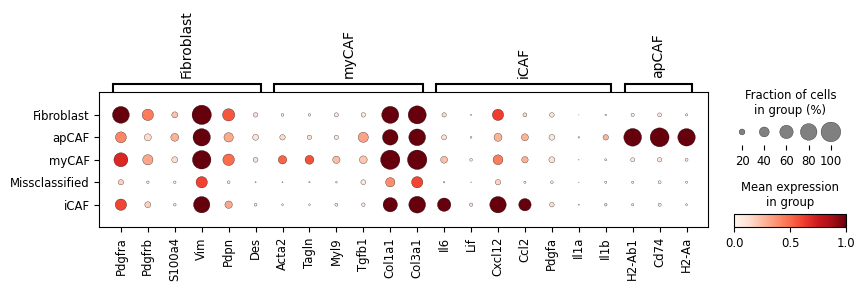

In [92]:
CAF.obs['celltype'].replace({'Missclassi': 'Missclassified'}, inplace=True)
sc.pl.dotplot(CAF,  groupby = 'celltype', var_names = list(caf_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(CAF,  groupby = 'celltype', var_names = caf_markers, vmax=1, vmin=0)

In [93]:
CAF.obs['celltype'].unique().tolist()

['Fibroblast', 'apCAF', 'myCAF', 'Missclassified', 'iCAF']

In [117]:
caf_cells_map = {k:v for k,v in zip(list(CAF.obs_names), list(CAF.obs.celltype))}
dictionary_maps.append(caf_cells_map)

## Non malignant epithelial

In [95]:
NME = adata[adata.obs['Level_1_refined'].isin(["Non Malignant Epithelial Cell"])].copy()

In [ ]:
nme_markers = {
    "Alpha Cell": ["Gcg", "Arx", "Mafb"],
    "Beta Cell": ["Ins1", "Ins2", "Pdx1", "Nkx6-1"],
    "Delta Cell": ["Sst", "Hhex", "Rbp4"],
    "Epsilon Cell": ["Ghrl", "Npy"],
    "Gamma Cell": ["Ppy", "Pax6"],
    "Ductal Cell": ["Krt19", "Hnf1b", "Cftr"],
    "ADM Cell": ["Sox9", "Hnf1b", "Muc6", "Tff2"],
    "Acinar Cell": ["Ptf1a", "Cela1", "Cpa1", "Prss1"],
    "Acinar (REG+) Cell": ["Reg3a", "Reg3b", "Reg1", "Reg2"],
    "Acinar Idling Cell": ["Nr5a2", "Rbpjl"]
}

In [97]:
for cell_type, markers in nme_markers.items():
    sc.tl.score_genes(NME, gene_list=markers, score_name=cell_type)
celltypes = []
scores = NME.obs[list(nme_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(nme_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

NME.obs['celltype'] = celltypes


In [98]:
NME.obs['celltype'].unique().tolist()

['Acinar (Reg +) Cell',
 'ADM Cell',
 'Ductal Cell',
 'Delta Cell',
 'Acinar Cell',
 'Epsilon Cell',
 'Beta Cell',
 'Acinar Idling Cell',
 'Gamma Cell',
 'Missclassified',
 'Alpha Cell']

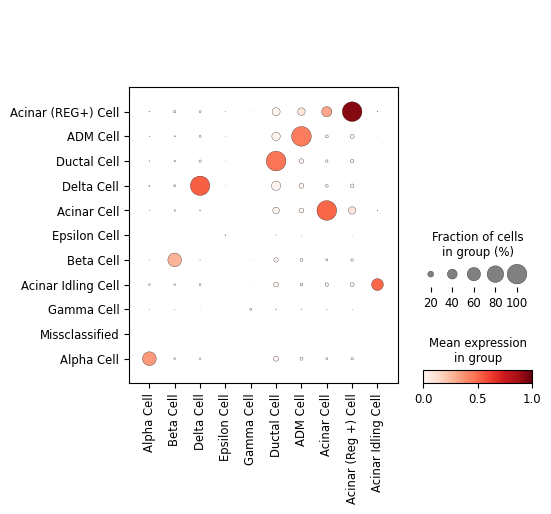

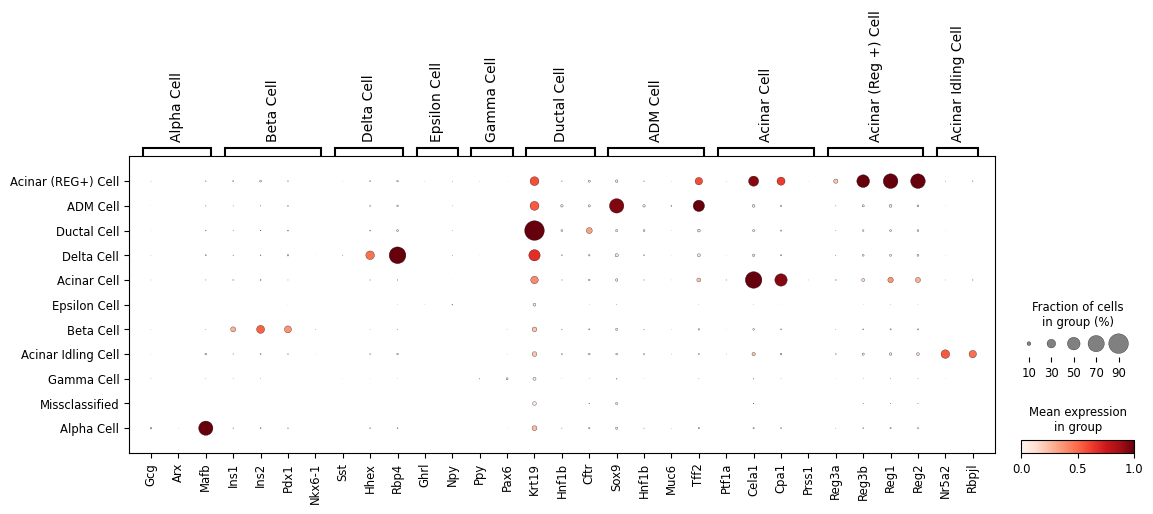

In [ ]:
sc.pl.dotplot(NME,  groupby = 'celltype', var_names = list(nme_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(NME,  groupby = 'celltype', var_names = nme_markers, vmax=1, vmin=0)

In [118]:
nme_cells_map = {k:v for k,v in zip(list(NME.obs_names), list(NME.obs.celltype))}
dictionary_maps.append(nme_cells_map)

## Malignant epithelial

In [101]:
ME = adata[adata.obs['Level_1_refined'].isin(["Malignant Epithelial Cell"])].copy()

In [ ]:
Basal:
VGLL1	UCA1	S100A2	LY6D	SPRR3	SPRR1B	LEMD1	KRT15	CTSL2	DHRS9	AREG	CST6	SERPINB3	KRT6C	KRT6A	SERPINB4	FAM83A	SCEL	FGFBP1	KRT7	KRT17	GPR87	TNS4	SLC2A1	ANXA8L2



classical:
    
BTNL8	FAM3D	ATAD4	AGR3	CTSE	LOC400573	LYZ	TFF2	TFF1	ANXA10	LGALS4	PLA2G10	CEACAM6	VSIG2	TSPAN8	ST6GALNAC1	AGR2	TFF3	CYP3A7	MYO1A	CLRN3	KRT20	CDH17	SPINK4	REG4

In [ ]:
me_markers = {
    "Malignant Cell - Classical": [
        "Fam3d",
        "Atad4",
        "Agr3",
        "Ctse",
        "Lyz2",
        "Tff2",
        "Tff1",
        "Anxa10",
        "Lgals4",
        "Pla2g10",
        "Vsig2",
        "Tspan8",
        "St6galnac1",
        "Agr2",
        "Tff3",
        "Myo1a",
        "Clrn3",
        "Krt20",
        "Cdh17",
        "Reg4"
    ],
    "Malignant Cell - Basal": [
        "Vgll1",
        "S100a2",
        "Ly6d",
        "Sprr3",
        "Sprr1b",
        "Lemd1",
        "Krt15",
        "Dhrs9",
        "Areg",
        "Cst6",
        "Serpinb3a",
        "Krt6a",
        "Fam83a",
        "Scel",
        "Fgfbp1",
        "Krt7",
        "Krt17",
        "Gpr87",
        "Tns4",
        "Slc2a1",
        "Anxa8"
    ]
}


In [103]:
for cell_type, markers in me_markers.items():
    sc.tl.score_genes(ME, gene_list=markers, score_name=cell_type)
celltypes = []
scores = ME.obs[list(me_markers.keys())].values

max_indices = np.argmax(scores, axis=1)
celltypes = np.array(list(me_markers.keys()))[max_indices]

#np.mean(scores) * np.std(scores) * 50
max_scores = scores[np.arange(scores.shape[0]), max_indices]
celltypes[max_scores < threshold] = "Missclassified"

ME.obs['celltype'] = celltypes


In [104]:
ME.obs['celltype'].unique().tolist()

['Malignant Cell - Classical', 'Malignant Cell - Basal', 'Missclassified']

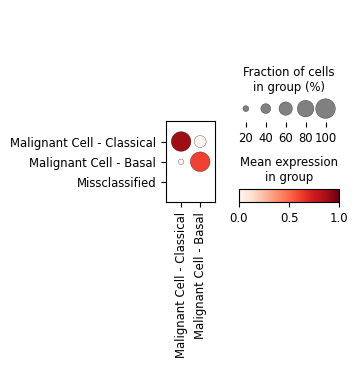

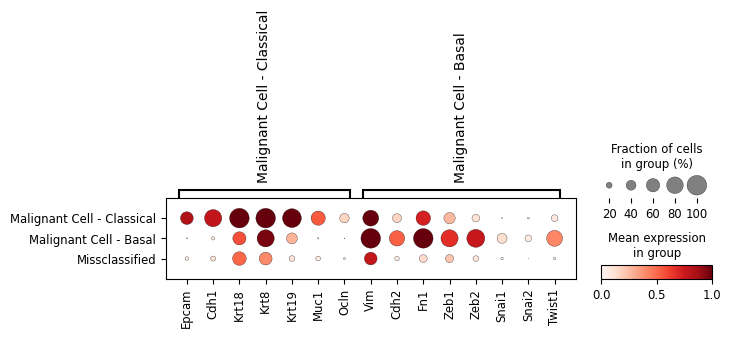

In [105]:
ME.obs['celltype'].replace({'Missclass': 'Missclassified'}, inplace=True)
sc.pl.dotplot(ME,  groupby = 'celltype', var_names = list(me_markers.keys()), vmax=1, vmin=0)
sc.pl.dotplot(ME,  groupby = 'celltype', var_names = me_markers, vmax=1, vmin=0)

In [119]:
me_cells_map = {k:v for k,v in zip(list(ME.obs_names), list(ME.obs.celltype))}
dictionary_maps.append(me_cells_map)

## add to anndata

In [120]:
dictionary_maps_ = {k: v for d in dictionary_maps for k, v in d.items()}


In [126]:
anno_map = pd.Series(dictionary_maps_)

In [127]:
anno_map.replace({'Acinar (Reg +) Cell': 'Acinar (REG+) Cell'}, inplace=True)


In [ ]:
adata.obs['Level_3'] = anno_map
adata.obs['Level_3'] = adata.obs['Level_3'].fillna(adata.obs['Level_1_refined'])

## inspect missclassified cells

In [ ]:
adata.obs['Level_3'].replace('Cd8+ T Cells', 'CD8+ T Cell', inplace=True)

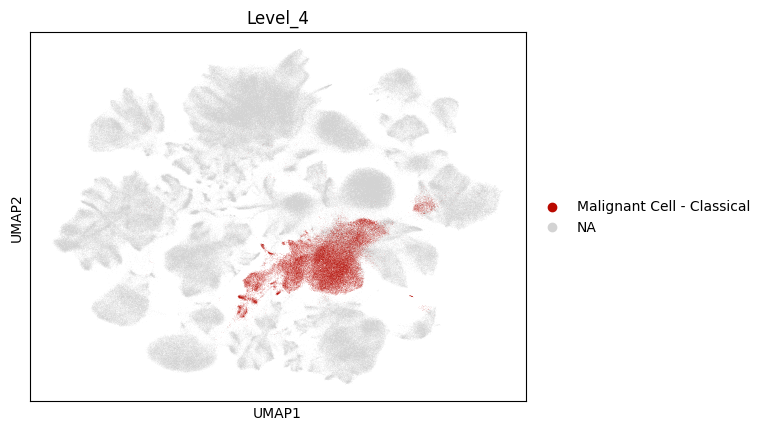

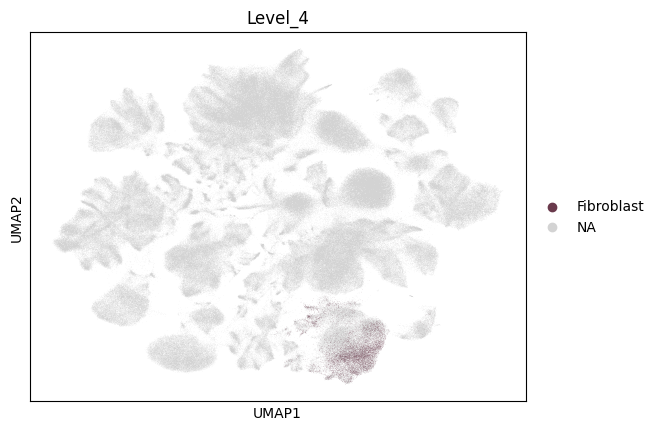

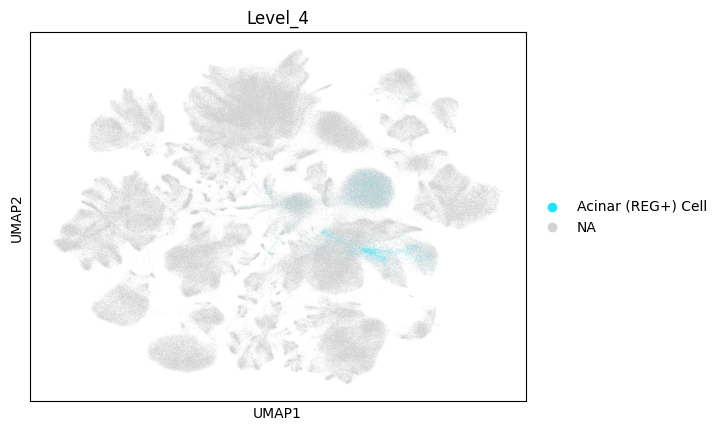

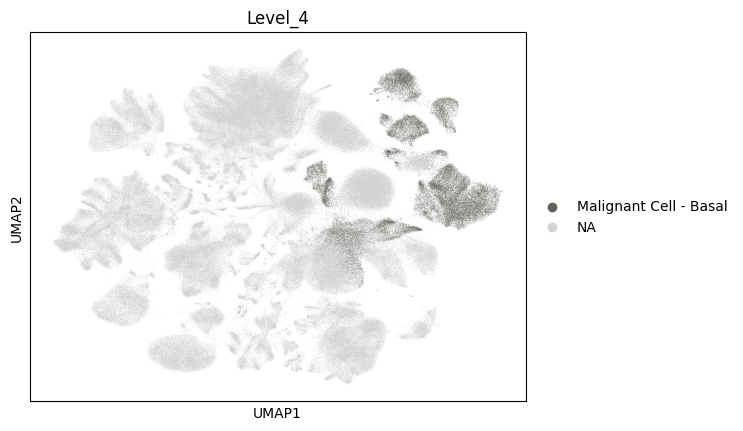

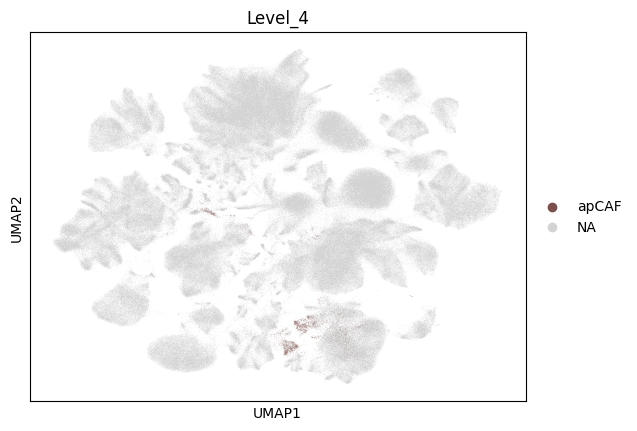

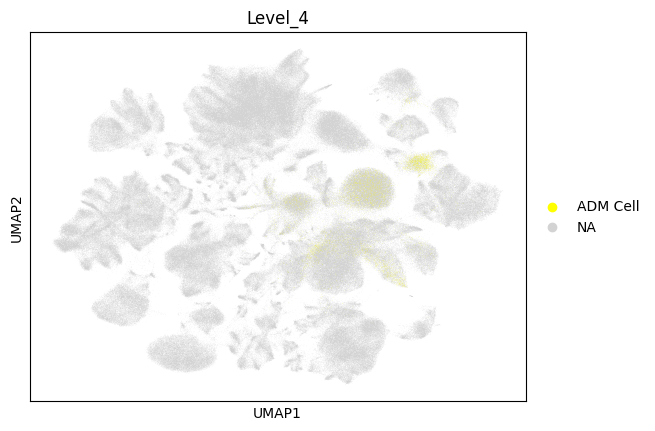

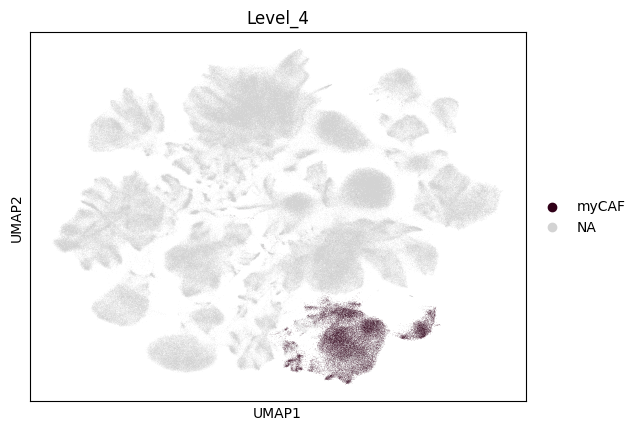

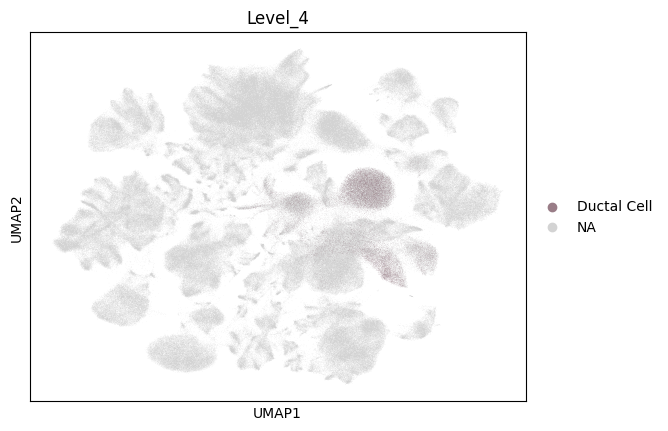

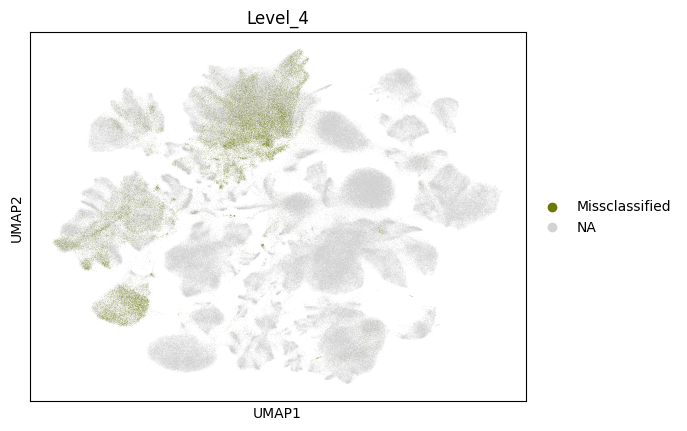

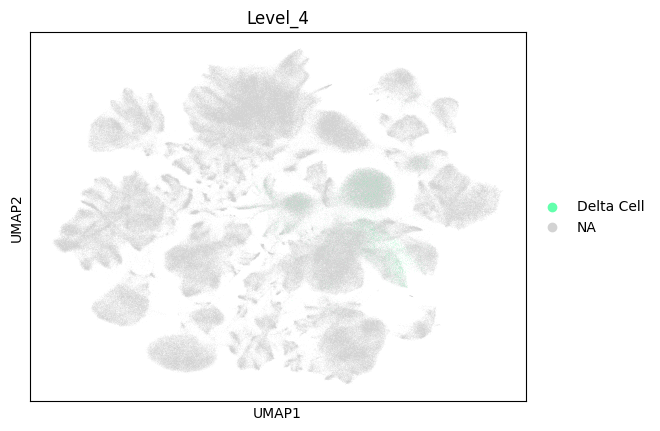

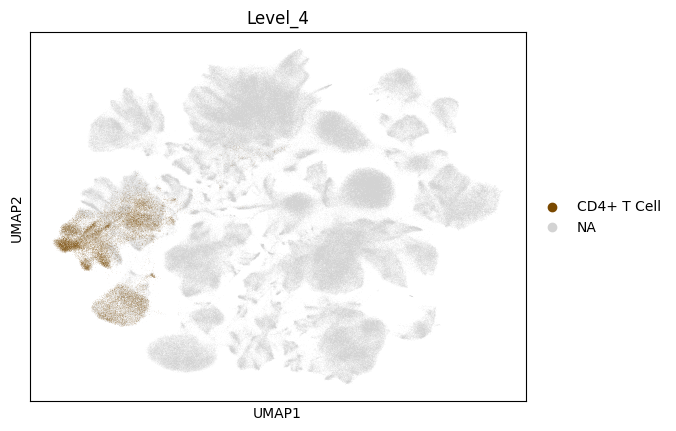

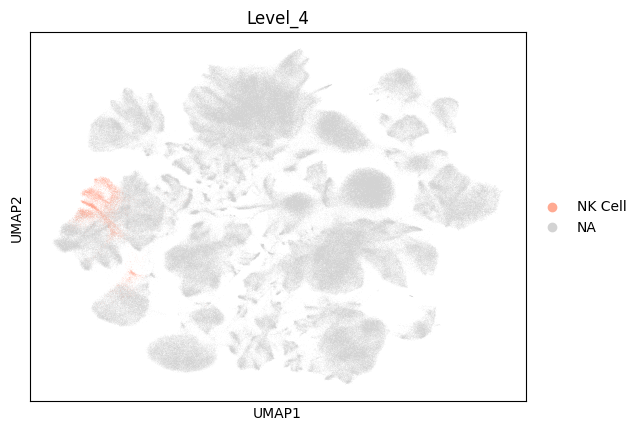

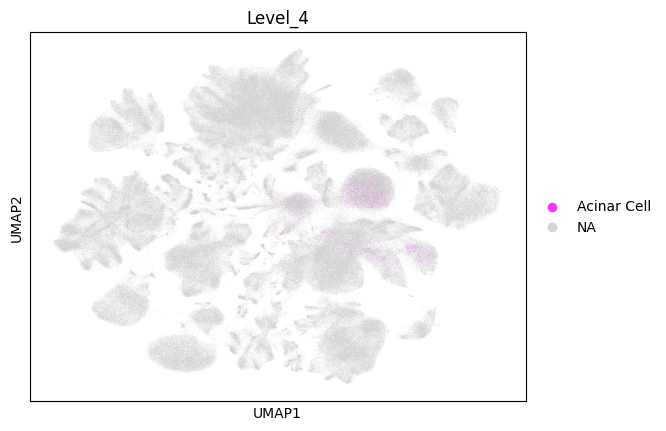

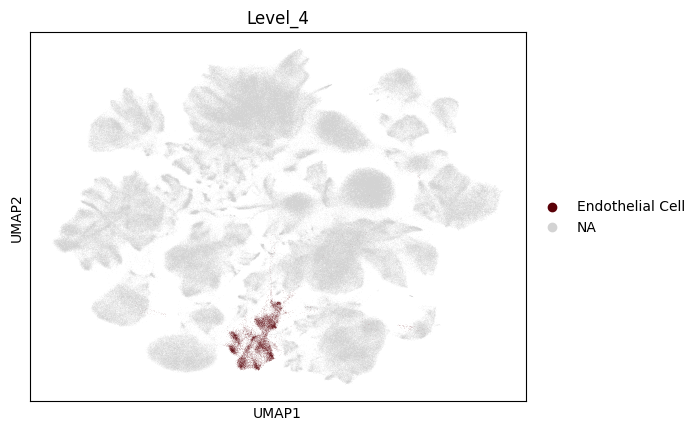

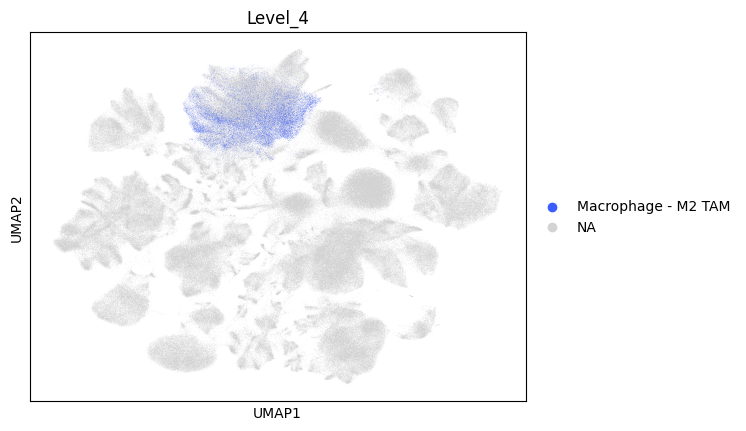

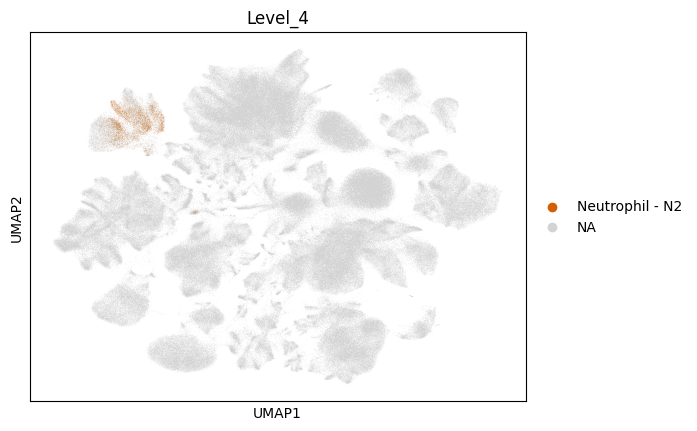

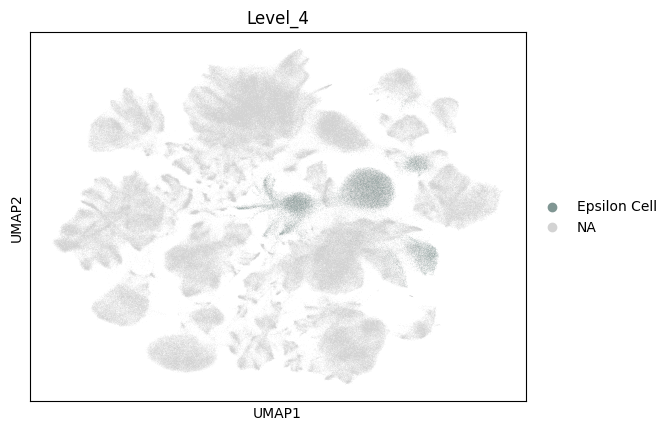

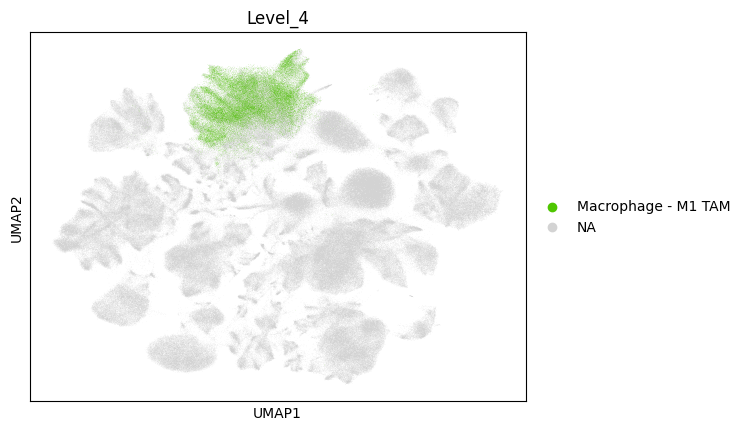

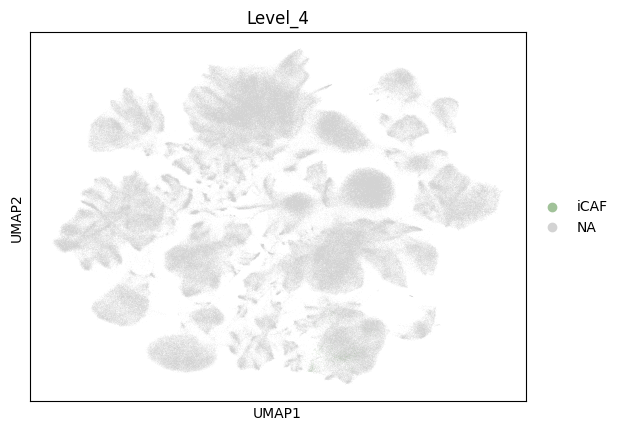

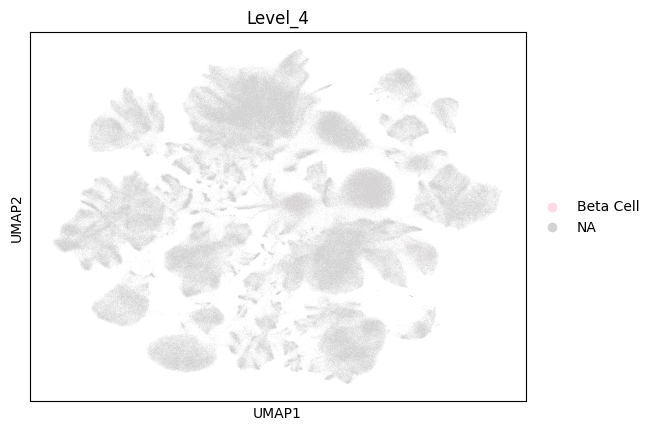

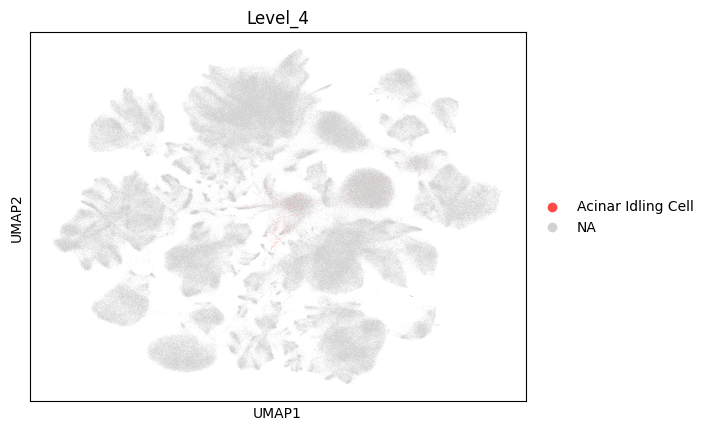

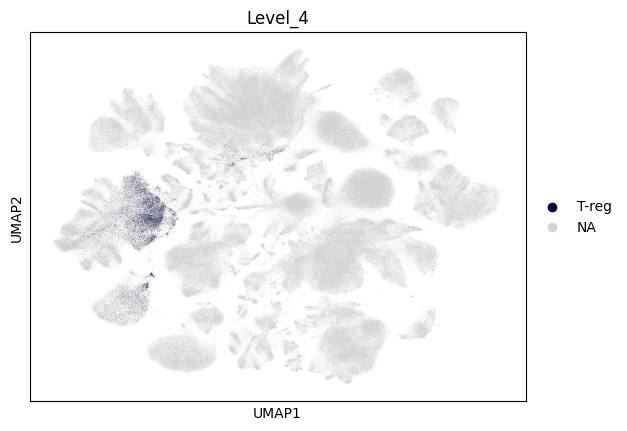

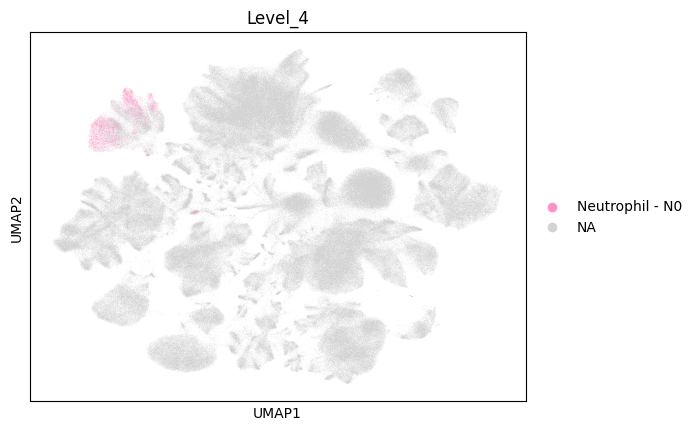

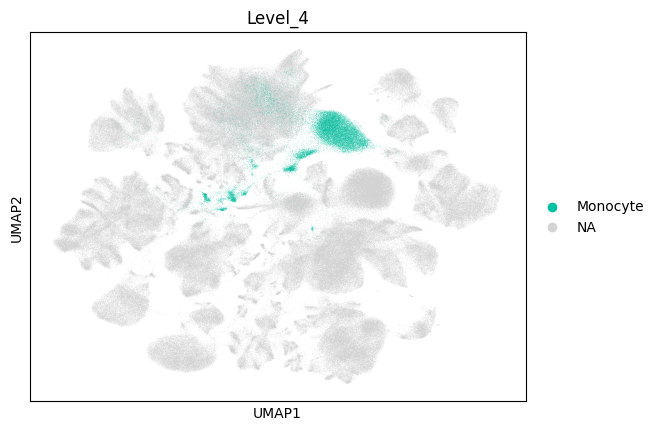

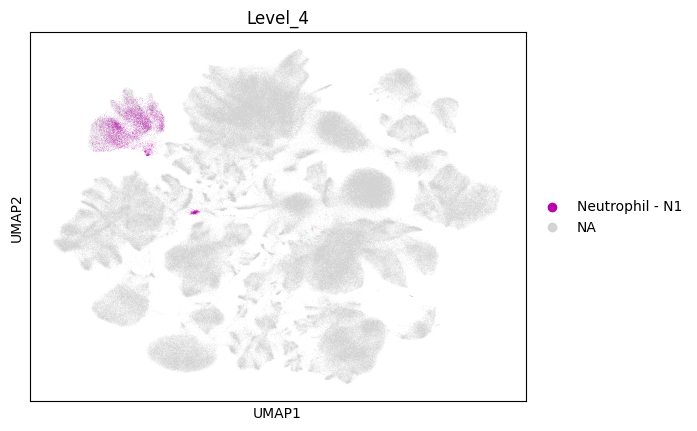

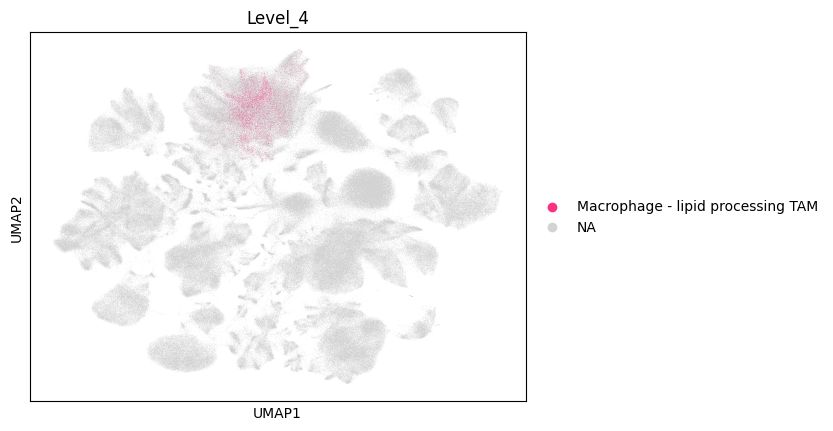

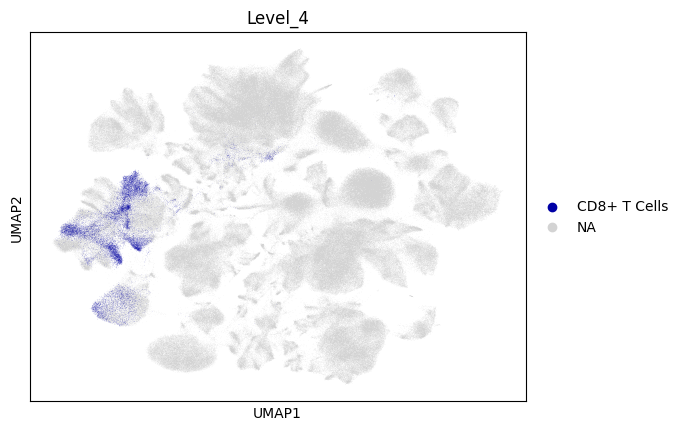

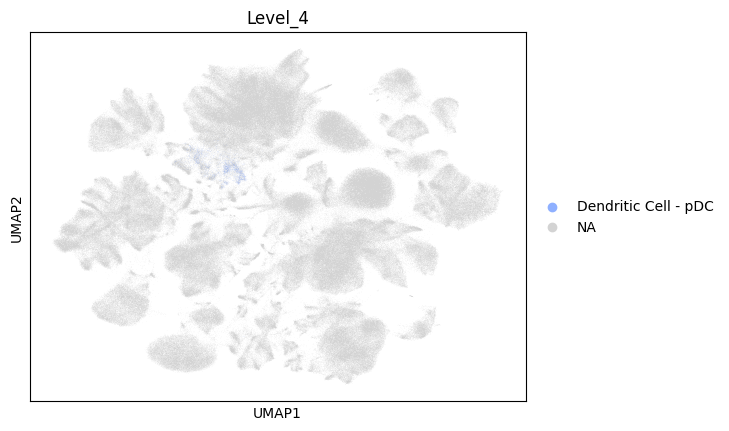

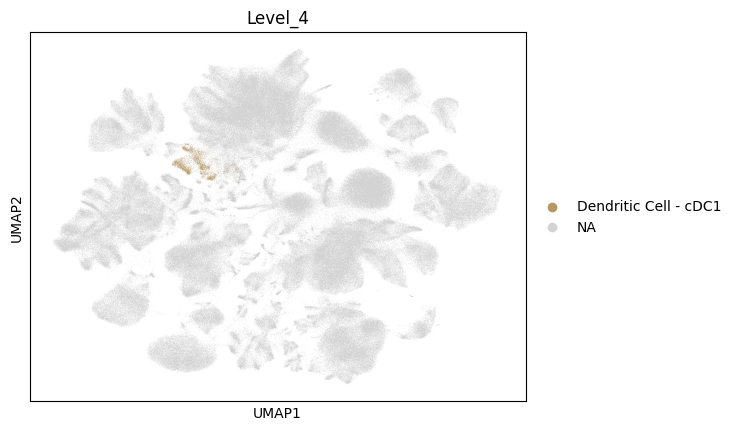

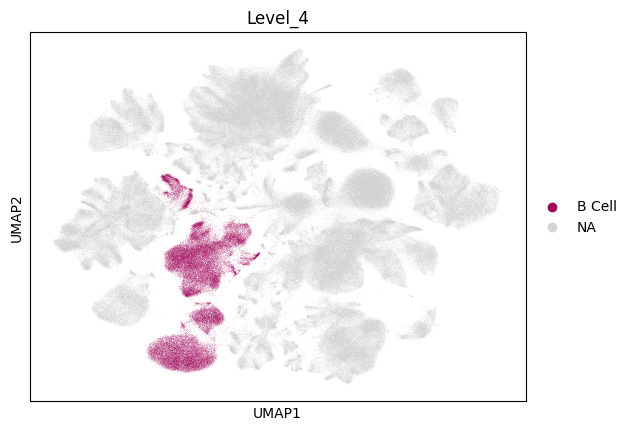

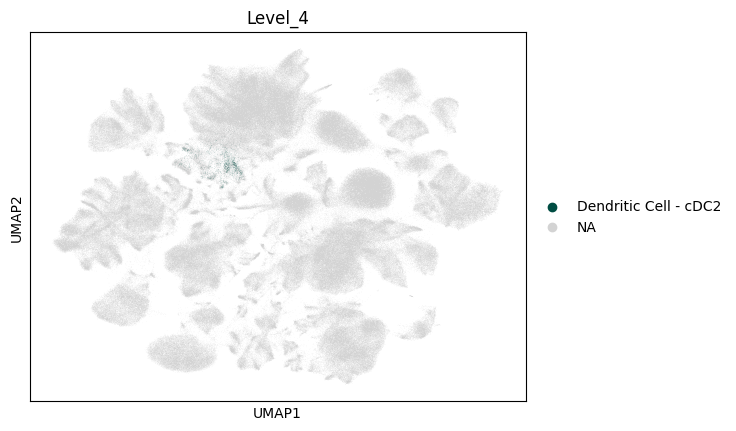

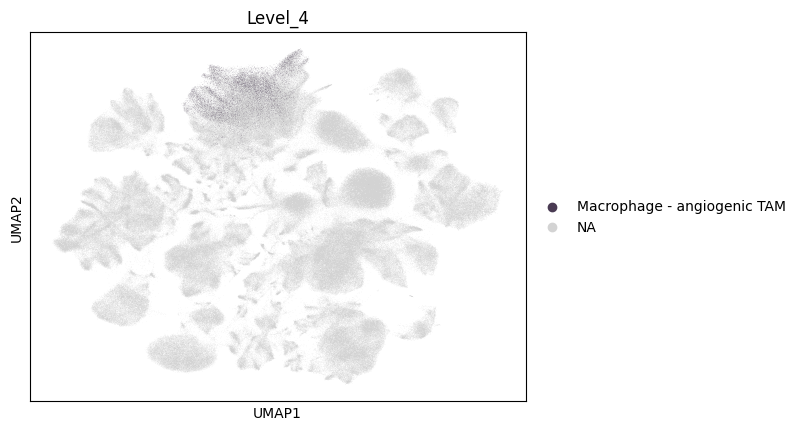

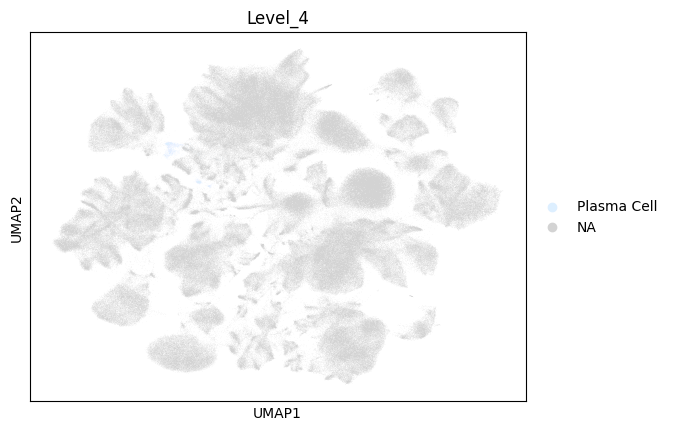

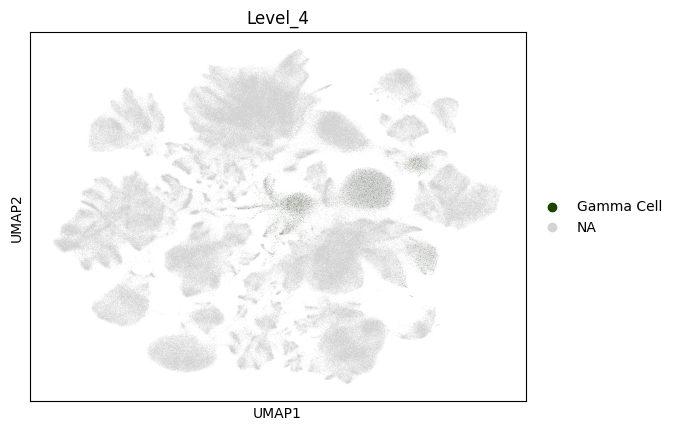

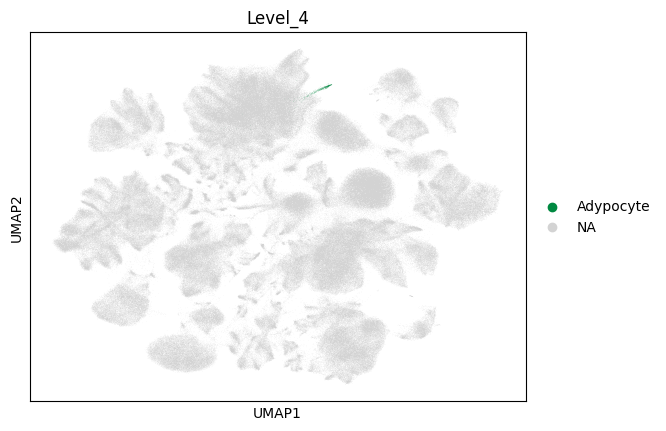

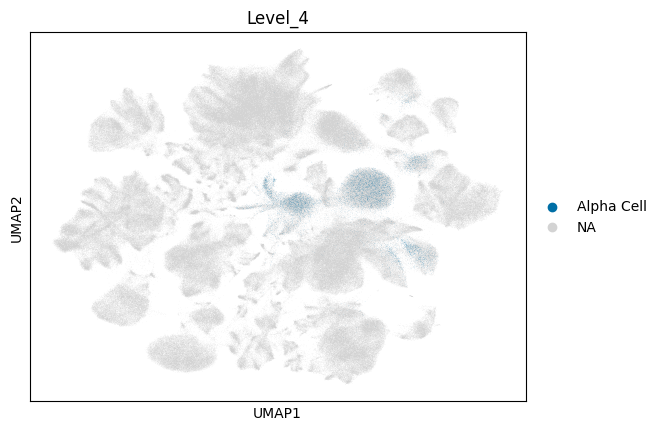

In [ ]:
for cell in adata.obs['Level_3'].unique():
    sc.pl.umap(adata, color = 'Level_3', groups = [cell],  )

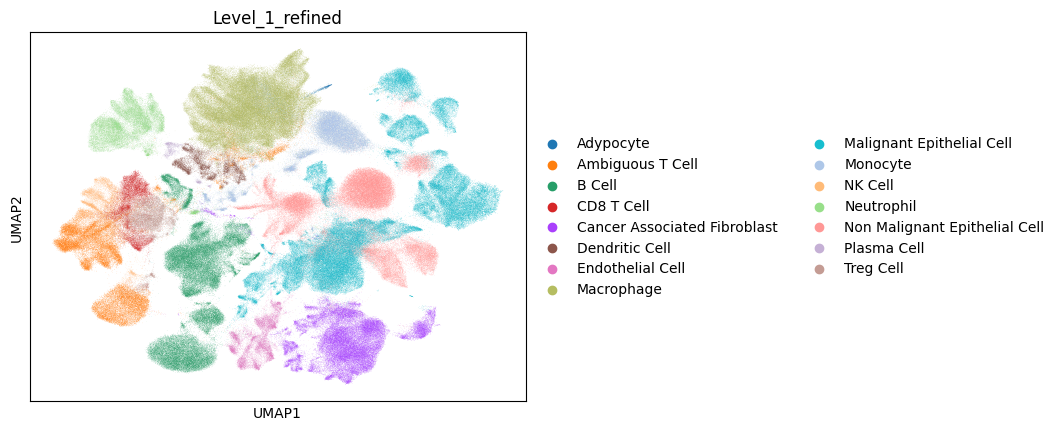

In [138]:
sc.pl.umap(adata, color = 'Level_1_refined',)

In [ ]:
missclassified = adata[adata.obs['Level_3'] == 'Missclassified'].copy()
sc.pp.neighbors(missclassified, transformer=AnnoyTransformer(15), use_rep='scANVI_emb')
sc.tl.umap(missclassified)

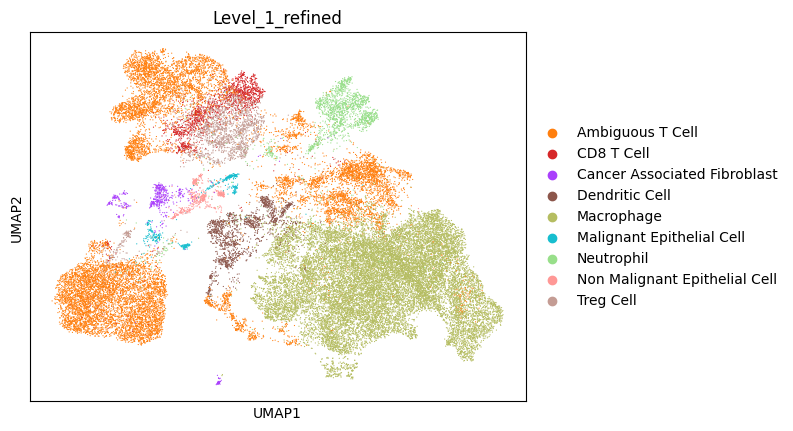

In [140]:
sc.pl.umap(missclassified, color = 'Level_1_refined',)

In [180]:
sc.tl.leiden(missclassified, flavor='igraph', resolution=0.25)

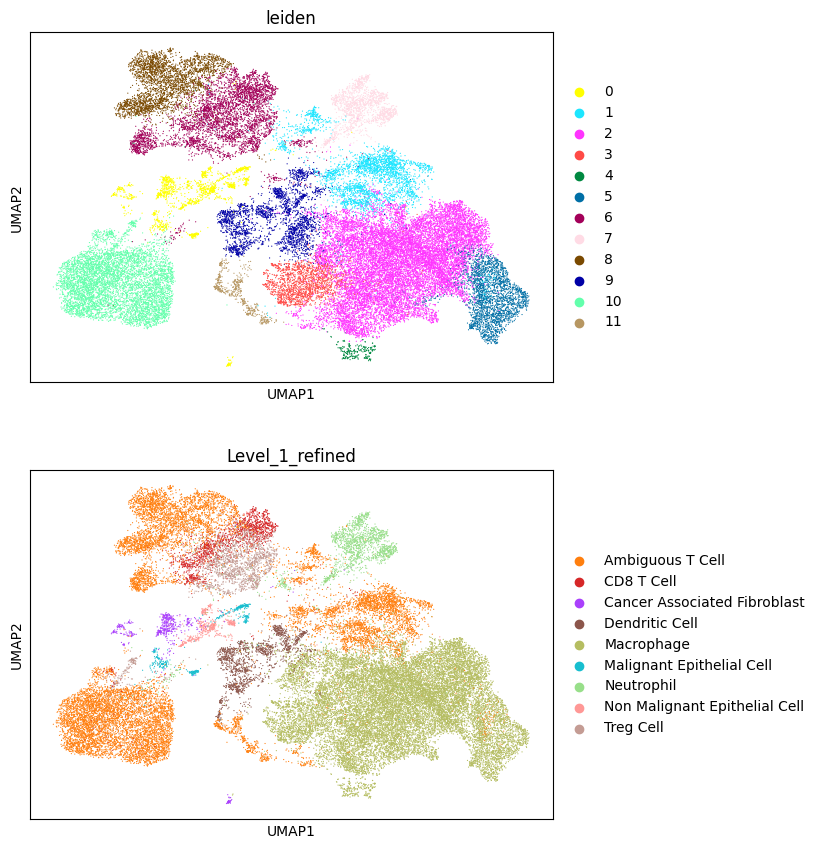

In [181]:
sc.pl.umap(missclassified, color = ['leiden','Level_1_refined'], ncols=1)

In [153]:
sc.tl.dendrogram(missclassified, groupby='leiden', use_rep='scANVI_emb')

In [169]:
[str(i) for i in range(0, 10)]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

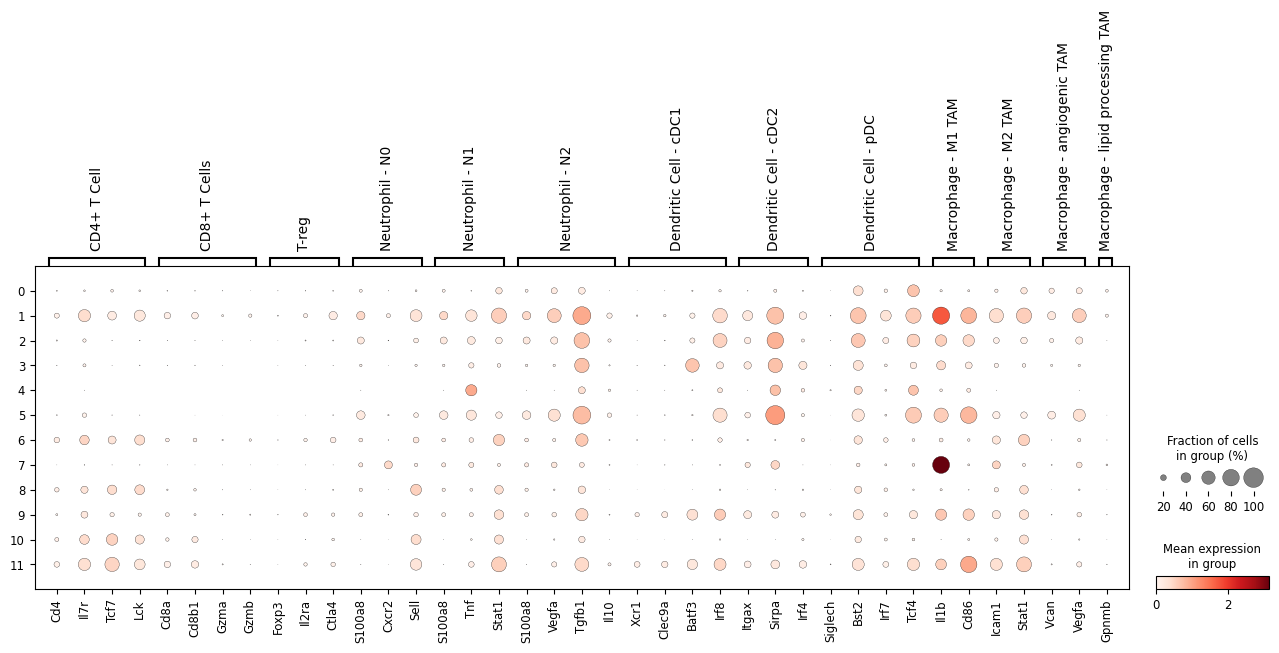

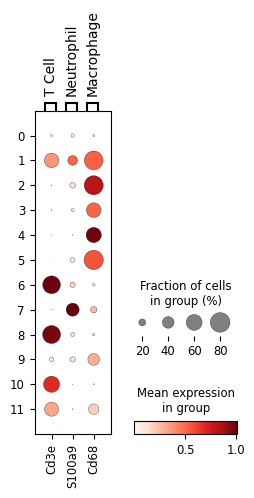

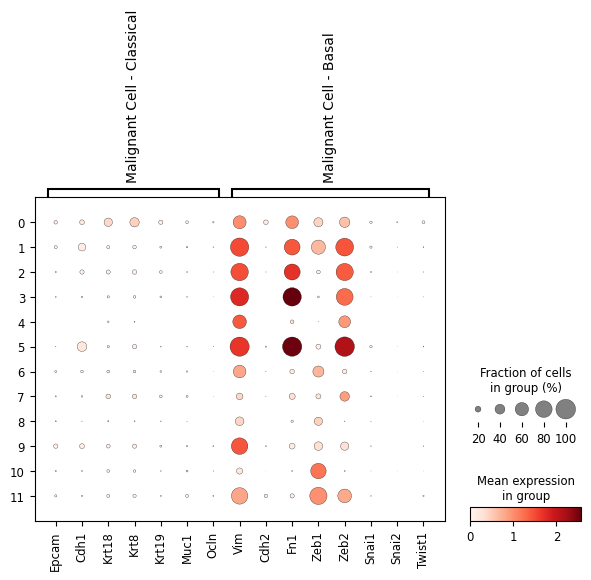

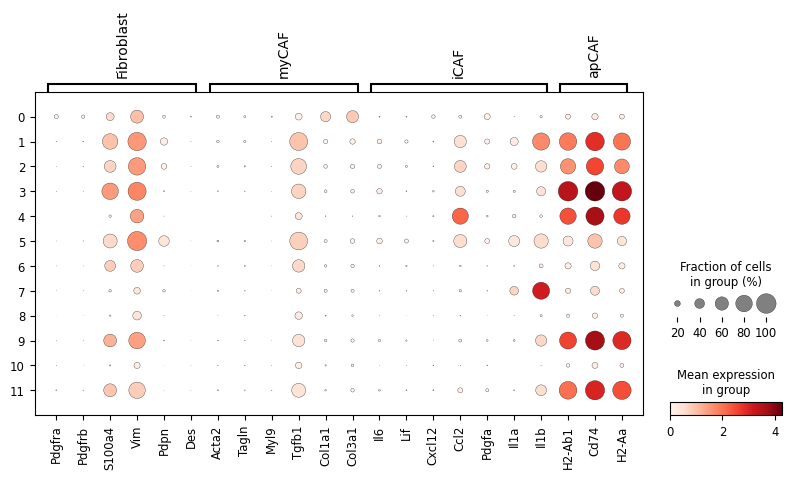

In [186]:
immune_markers = {**t_cell_markers, **neutrophil_markers, **dendritic_markers, **macrophage_markers}
immune_markers_coarse = {
    "T Cell": 'Cd3e',
    "Neutrophil": 'S100a9',
    'Macrophage': 'Cd68',
}
print('='*50)
sc.pl.dotplot(missclassified, groupby = 'leiden', var_names = immune_markers, dendrogram=False, categories_order=[str(i) for i in range(0, 12)])
sc.pl.dotplot(missclassified, groupby = 'leiden', var_names = immune_markers_coarse, dendrogram=False,categories_order=[str(i) for i in range(0, 12)])
sc.pl.dotplot(missclassified, groupby = 'leiden', var_names = me_markers, dendrogram=False, categories_order=[str(i) for i in range(0, 12)])
sc.pl.dotplot(missclassified, groupby = 'leiden', var_names = caf_markers, dendrogram=False, categories_order=[str(i) for i in range(0, 12)])

print('='*50)

In [194]:
anno = {
    "0":'myCAF',
    "1":'Macrophage - CD3+ TAM',
    "2":'Macrophage - M1 TAM',
    "3":'Macrophage - M1 TAM',
    "4":'Macrophage - M1 TAM',
    "5":'Macrophage - M1 TAM',
    "6":'CD4+ T Cell',
    "7":'Neutrophil - N0',
    "8":'CD4+ T Cell',
    "9":'Macrophage - M1 TAM',
    "10":'CD4+ T Cell',
    "11":'CD4+ T Cell',
}

In [ ]:
missclassified.obs.Level_3 = missclassified.obs['leiden'].replace(anno)
anno_map = missclassified.obs['Level_3']


In [ ]:
adata.obs['Level_3'] = adata.obs['Level_3'].astype(str)
adata.obs['Level_3'].loc[missclassified.obs.index] = anno_map
adata.obs['Level_3'] = adata.obs['Level_3'].astype('category')


/tmp/ipykernel_3629327/2319828411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['Level_4'].loc[missclassified.obs.index] = anno_map


In [199]:
adata.obs['Level_3'].value_counts()

B Cell                               73971
Malignant Cell - Basal               73558
Macrophage - M1 TAM                  67574
Malignant Cell - Classical           57089
myCAF                                40956
CD4+ T Cell                          40429
Monocyte                             34341
Macrophage - M2 TAM                  22474
Epsilon Cell                         22298
CD8+ T Cells                         18860
Ductal Cell                          18389
Endothelial Cell                     13322
T-reg                                12469
NK Cell                              11889
Neutrophil - N1                      10542
Neutrophil - N0                      10030
Fibroblast                            9669
Macrophage - angiogenic TAM           9647
Macrophage - lipid processing TAM     8382
ADM Cell                              7496
Acinar (REG+) Cell                    7300
Alpha Cell                            6934
Dendritic Cell - cDC1                 5636
Delta Cell 

In [ ]:
adata.obs['Level_3'] = adata.obs['Level_3'].copy()
del adata.obs['Level_3']

In [ ]:
adata.write_h5ad('/mnt/storage/Daniele/atlases/mouse/13_mouse_all_annotated.h5ad')